<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.880 · TFM · Área 3 aula 1</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación

</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# TFM: 

## Clasificación de imágenes de recursión celular:

El coste de algunos medicamentos y tratamientos médicos ha subido tanto en los últimos años que muchos pacientes tienen que prescindir de ellos. Una de las razones más sorprendentes del coste es el tiempo que se tarda en sacar nuevos tratamientos al mercado. A pesar de las mejoras en la tecnología y la ciencia, la investigación y el desarrollo siguen retrasados. De hecho, encontrar nuevos tratamientos lleva, de media, más de 10 años y cuesta cientos de millones de dólares.

Recursion Pharmaceuticals, creadores del mayor conjunto de datos de imágenes biológicas del sector, generado íntegramente de forma interna, cree que la IA tiene el potencial de mejorar y agilizar drásticamente el proceso de descubrimiento de fármacos. Más concretamente, sus esfuerzos podrían ayudarles a entender cómo interactúan los fármacos con las células humanas.

En este proyecto se tiene que desentrañar el ruido experimental de las señales biológicas reales. La propuesta clasificará imágenes de células sometidas a una de las 1.108 perturbaciones genéticas diferentes. Puedes ayudar a eliminar el ruido introducido por la ejecución técnica y la variación ambiental entre experimentos.

Si se tiene éxito, se podría mejorar drásticamente la capacidad de la industria para modelar imágenes celulares según su biología relevante. A su vez, la aplicación de la IA podría disminuir en gran medida el coste de los tratamientos y garantizar que estos lleguen a los pacientes con mayor rapidez.


El proyecto que se presenta es el reto de la plataforma Kaggle alojado en https://www.kaggle.com/c/recursion-cellular-image-classification. Uno de los principales retos para aplicar la IA a los datos de microscopía biológica es que incluso las réplicas más cuidadosas de un proceso no parecerán idénticas. Este conjunto de datos supone un reto para desarrollar un modelo de identificación de réplicas que sea robusto frente al ruido experimental.

Los mismos siRNAs (perturbaciones genéticas efectivas) se han aplicado repetidamente a múltiples líneas celulares, para un total de 51 lotes experimentales. Cada lote tiene cuatro placas, cada una de las cuales tiene 308 pozos llenos. Para cada pozo, se ha realizado imágenes de microscopio desde dos perspectivas y a través de seis canales de imagen. No todos los lotes tienen necesariamente todos los pozos llenos o todos los siRNA presentes.

Hemos resumido esta descripción a lo esencial; para más detalles, consulte [RxRx.ai](https://www.rxrx.ai).


**El objetivo principal de la práctica es desarrollar modelos basados en el aprendizaje automático para clasificar con la mayor precisión posible, las perturbaciones genéticas aplicadas a las células.**

In [6]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np # linear algebra
warnings.filterwarnings('ignore')
import random

In [2]:
!git clone https://github.com/recursionpharma/rxrx1-utils

Cloning into 'rxrx1-utils'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 127 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (127/127), 1.59 MiB | 3.09 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [3]:
sys.path.append('rxrx1-utils')
import rxrx.io as rio

### Cargar una perspectiva (site) y visualizar los canales

Se utiliza la función load_site que se encuentra en tools_tfm.py para obtener el tensor de imágenes de 512 x 512 x 6 de un 'site'. Los argumentos de load_site le indican qué imagen se quiere visualizar. En el ejemplo siguiente, desde el conjunto train, solicitamos la imagen del experimento RPE-05 en la placa 3 en el pozo D19 en el 'site' 2.

In [4]:
t = rio.load_site('train', 'RPE-05', 3, 'D19', 2)
t.shape

2022-05-12 18:07:53.784710: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


(512, 512, 6)

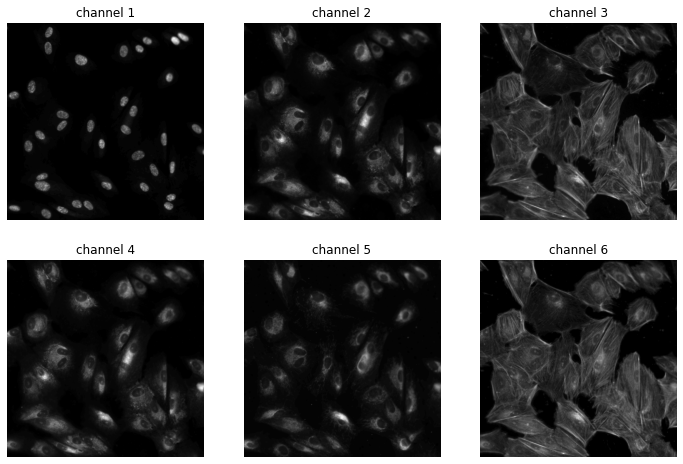

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
  ax.axis('off')
  ax.set_title('channel {}'.format(i + 1))
  _ = ax.imshow(t[:, :, i], cmap='gray')

In [8]:
x = rio.convert_tensor_to_rgb(t)

x.shape

(512, 512, 3)

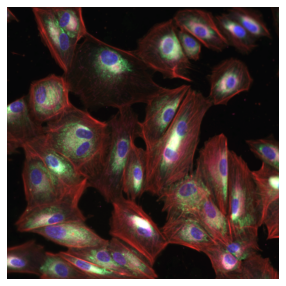

In [9]:
plt.figure(figsize=(5, 5))
plt.axis('off')

_ = plt.imshow(x)

### Cargar y convertir a RGB

Por conveniencia, hay una contenedor alrededor de estas dos funciones llamada `load_site_as_rgb` con los mismos parámetros que `load_site`

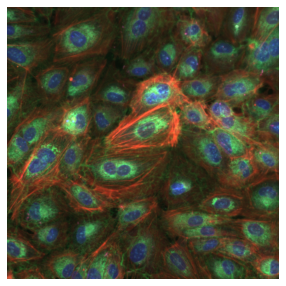

In [10]:
y = rio.load_site_as_rgb('train', 'HUVEC-08', 4, 'K09', 1)

plt.figure(figsize=(5, 5))
plt.axis('off')

_ = plt.imshow(y)

### A continuación trabajaremos con los nuevas imágenes de 224x244

In [25]:
root_dir_train = '../input/recursion-cellular-image-classification-224-jpg/train/train/'

In [11]:
df_train = pd.read_csv('../input/recursion-cellular-image-classification-224-jpg/new_train.csv')
df_test = pd.read_csv('../input/recursion-cellular-image-classification-224-jpg/new_test.csv')

In [12]:
df_train['cell_type'] = df_train['experiment'].str.split('-').str[0]
df_test['cell_type'] = df_test['experiment'].str.split('-').str[0]

In [13]:
print("Unique values from train: ")
for col in df_train.columns[1:]:
    print(str(col),": " , len(df_train[col].unique()))

Unique values from train: 
experiment :  33
plate :  4
well :  277
sirna :  1108
filename :  73030
cell_type :  4


Cell types: 
HUVEC    35376
RPE      15506
HEPG2    15500
U2OS      6648
Name: cell_type, dtype: int64


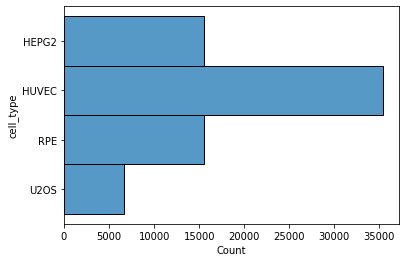

In [14]:
print("Cell types: ")
print(df_train['cell_type'].value_counts())
sns.histplot(data=df_train, y='cell_type') #df_train['cell_type'].hist()
plt.show()

Cell types: 
HUVEC    17692
HEPG2     8858
RPE       8834
U2OS      4410
Name: cell_type, dtype: int64


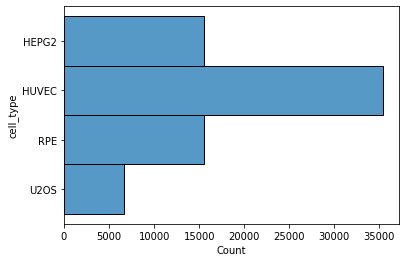

In [15]:
print("Cell types: ")
print(df_test['cell_type'].value_counts())
sns.histplot(data=df_train, y='cell_type') #df_train['cell_type'].hist()
plt.show()

Experiment: 
HUVEC-22    2216
RPE-08      2216
HEPG2-10    2216
U2OS-04     2216
HUVEC-17    2216
RPE-10      2216
HUVEC-19    2216
HUVEC-20    2216
HUVEC-21    2216
HEPG2-09    2216
RPE-09      2214
HEPG2-08    2214
HUVEC-18    2214
HEPG2-11    2212
HUVEC-24    2200
HUVEC-23    2198
U2OS-05     2194
RPE-11      2188
Name: experiment, dtype: int64


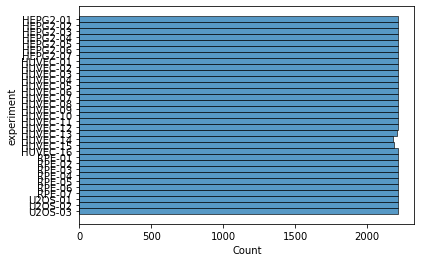

In [16]:
print("Experiment: ")
print(df_test['experiment'].value_counts())
sns.histplot(data=df_train, y='experiment') #df_train['cell_type'].hist()
plt.show()

Sirna: 


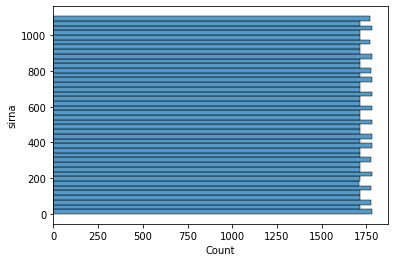

In [17]:
print("Sirna: ")
sns.histplot(data=df_train, y='sirna') #df_train['cell_type'].hist()
plt.show()

In [18]:
df_train.groupby(['cell_type', 'experiment']).size()

cell_type  experiment
HEPG2      HEPG2-01      2212
           HEPG2-02      2212
           HEPG2-03      2216
           HEPG2-04      2216
           HEPG2-05      2216
           HEPG2-06      2216
           HEPG2-07      2212
HUVEC      HUVEC-01      2216
           HUVEC-02      2216
           HUVEC-03      2216
           HUVEC-04      2216
           HUVEC-05      2216
           HUVEC-06      2214
           HUVEC-07      2214
           HUVEC-08      2216
           HUVEC-09      2216
           HUVEC-10      2216
           HUVEC-11      2216
           HUVEC-12      2216
           HUVEC-13      2204
           HUVEC-14      2180
           HUVEC-15      2188
           HUVEC-16      2216
RPE        RPE-01        2216
           RPE-02        2216
           RPE-03        2216
           RPE-04        2214
           RPE-05        2216
           RPE-06        2212
           RPE-07        2216
U2OS       U2OS-01       2216
           U2OS-02       2216
           U2OS-03

In [19]:
df_train_group = [df_train for _, df_train in df_train.groupby('experiment')]
random.shuffle(df_train_group)

In [20]:
df_train_group = pd.concat(df_train_group).reset_index(drop=True)

In [21]:
df_train.groupby('cell_type').experiment.nunique()

cell_type
HEPG2     7
HUVEC    16
RPE       7
U2OS      3
Name: experiment, dtype: int64

In [22]:
df_test.groupby('cell_type').experiment.nunique()

cell_type
HEPG2    4
HUVEC    8
RPE      4
U2OS     2
Name: experiment, dtype: int64

### Visualizamos aleatoriamente algunas imágenes

In [23]:
sample_image = df_train['filename'].sample(16)

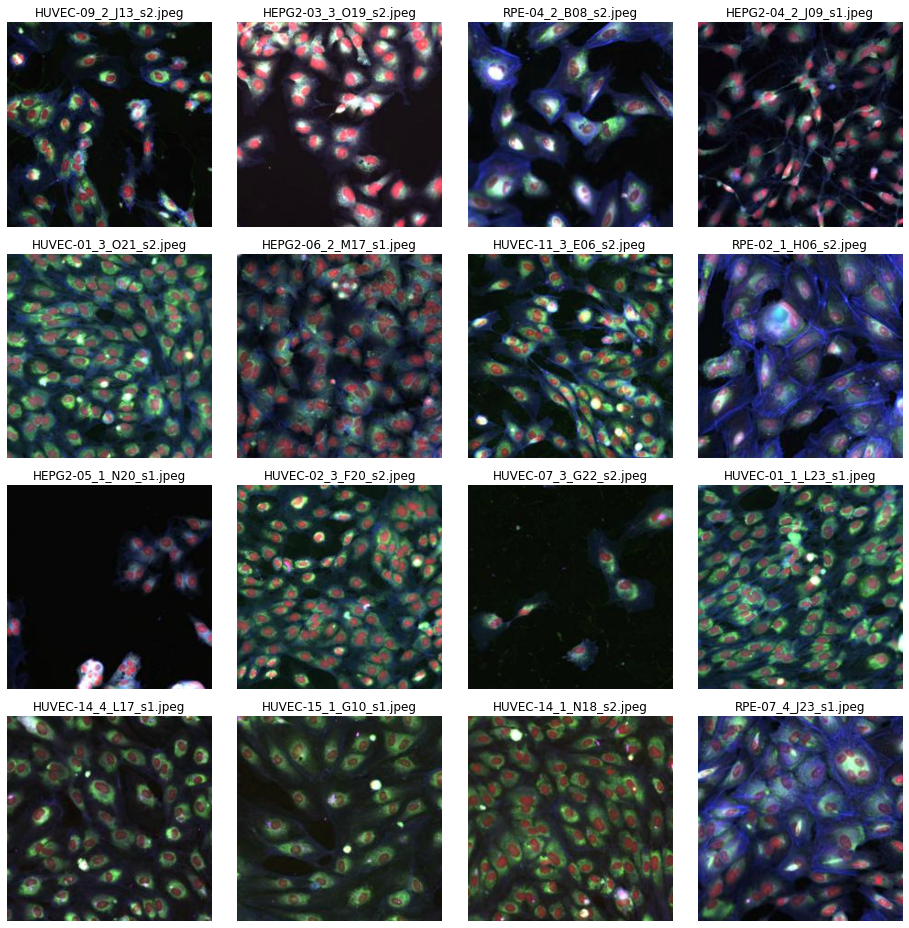

In [27]:
fig, axis = plt.subplots(nrows = 4, ncols = 4, figsize=(13, 13))

for i, (ax, dir_imag) in enumerate(zip(axis.reshape(-1), sample_image)):
    ax.set_title(dir_imag)
    path = root_dir_train + dir_imag
    ax.imshow(cv2.imread(path))
    ax.axis('off')
plt.tight_layout()